## 미션 6. “나이대별로 의료비 차이가 뚜렷할까?”

6-1 age를 여러 구간으로 나누어(예: 18~30, 31~50, 51+) 각 연령대별 charges 분포를 시각화한다.

In [24]:
df['age']

0       19
1       18
2       28
3       33
4       32
        ..
1333    50
1334    18
1335    18
1336    21
1337    61
Name: age, Length: 1338, dtype: int64

In [25]:
bins = [17, 30, 50, dfl['age'].max()]
labels = ['18~30', '31~50', '51+']

dfl['age_group'] = pd.cut(dfl['age'], bins=bins, labels=labels)
dfl['age_group'].value_counts()

age_group
31~50    538
18~30    444
51+      356
Name: count, dtype: int64

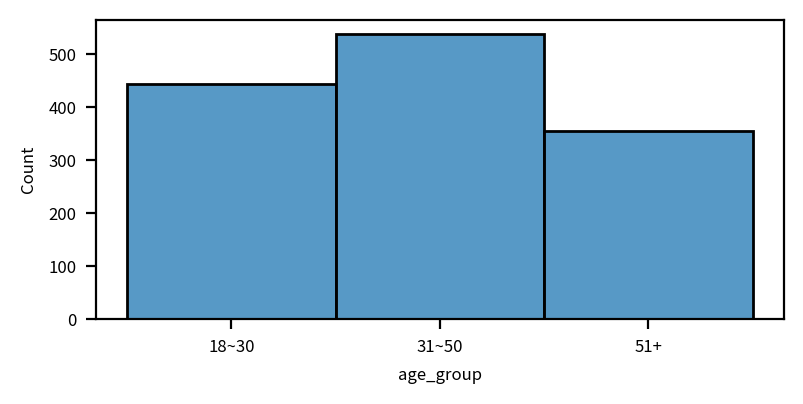

In [26]:
width_px  = 800
height_px = 400
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=my_dpi)

sb.histplot(data=dfl['age_group'], bins=5)

plt.tight_layout()
plt.show()
plt.close()

각 그룹의 빈도를 보여줄 뿐 charges의 분포를 보여주지 않는다. 따라서 age_group별 charges의 분포를 비교하는 시각화를 작성하면 좋을것

6-2 분산분석(ANOVA)으로 전체 차이를 확인하고, 사후검정으로 어느 연령대 사이에서 차이가 나는지 정리한다.

정규성, 등분산성, 독립성(있다 라는 가정) 검정 실시

정규성 검정 실시, 결과 : 3구간 모두 귀무가설 기각 즉 정규성 만족하지 않음

In [27]:
df6_1 = dfl[dfl['age_group'] == '18~30']
df6_2 = dfl[dfl['age_group'] == '31~50']
df6_3 = dfl[dfl['age_group'] == '51+']

In [28]:
print(stats.shapiro(df6_1['charges']), stats.shapiro(df6_2['charges']), stats.shapiro(df6_3['charges']))

ShapiroResult(statistic=np.float64(0.8720731010911933), pvalue=np.float64(1.1744696263988118e-18)) ShapiroResult(statistic=np.float64(0.8808859857624945), pvalue=np.float64(6.517883369596651e-20)) ShapiroResult(statistic=np.float64(0.799470610886889), pvalue=np.float64(1.1666973624974481e-20))


등분산성 검정실시, 결과 : 귀무가설 채택 즉 등분산임

In [29]:
stats.levene(df6_1['charges'], df6_2['charges'], df6_3['charges'])

LeveneResult(statistic=np.float64(78.71990387813368), pvalue=np.float64(4.815202388261656e-33))

정규성 X 임으로 쿠르스칼왈리스 검정 진행, 결과 : 귀무가설 기각 즉 나이대별 의료비 차이가 있다.

In [30]:
stats.kruskal(df6_1['charges'], df6_2['charges'], df6_3['charges'])

KruskalResult(statistic=np.float64(326.52421404125573), pvalue=np.float64(1.247865612614743e-71))

귀무가설 기각했으므로 사후검정 실시, 비모수임으로 게임호윌, 투키 사용 불가 따라서 Dunn검정 실시

In [31]:
import scikit_posthocs as sp

sp.posthoc_dunn(dfl,
    val_col='charges',
    group_col='age_group',
    p_adjust='bonferroni'
)

,18~30,31~50,51+
18~30,1.000000e+00,1.291882e-22,3.165927e-72
31~50,1.291882e-22,1.000000e+00,6.861434e-21
51+,3.165927e-72,6.861434e-21,1.000000e+00


사후검정 결과 18~30 구간과 51+ 구간의 차이가 가장 크고 그다음이 18~30, 30~50 이다.

## 미션 10. “의료비를 설명하는 회귀모형 설계”

In [41]:
model = ols('charges ~ age + C(sex) + bmi + children + C(smoker) + C(region)', data = dfl).fit()

In [42]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     549.8
Date:                Wed, 07 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:08:10   Log-Likelihood:                -808.52
No. Observations:                1338   AIC:                             1635.
Df Residuals:                    1329   BIC:                             1682.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  7

회귀식 : charges^ = 7.0306 -0.0754C(sex)[T.male] + 1.5543C(smoker)[T.yes] -0.0638C(region)[T.northwest] -0.1572C(region)[T.southeast] -0.1290C(region)[T.southwest] + 0.0346age^ + 0.0134bmi^ + 0.1019children^

다중선형회귀 가정 4가지(정규성, 선형성, 등분산성, 독립성)검정 실시

1. 정규성 검정, 결과 : 정규성 만족 안함, 하지만 qq플롯으로본 결과 비교적 회귀직선에 따르므로 회귀분석 그냥 진행가능

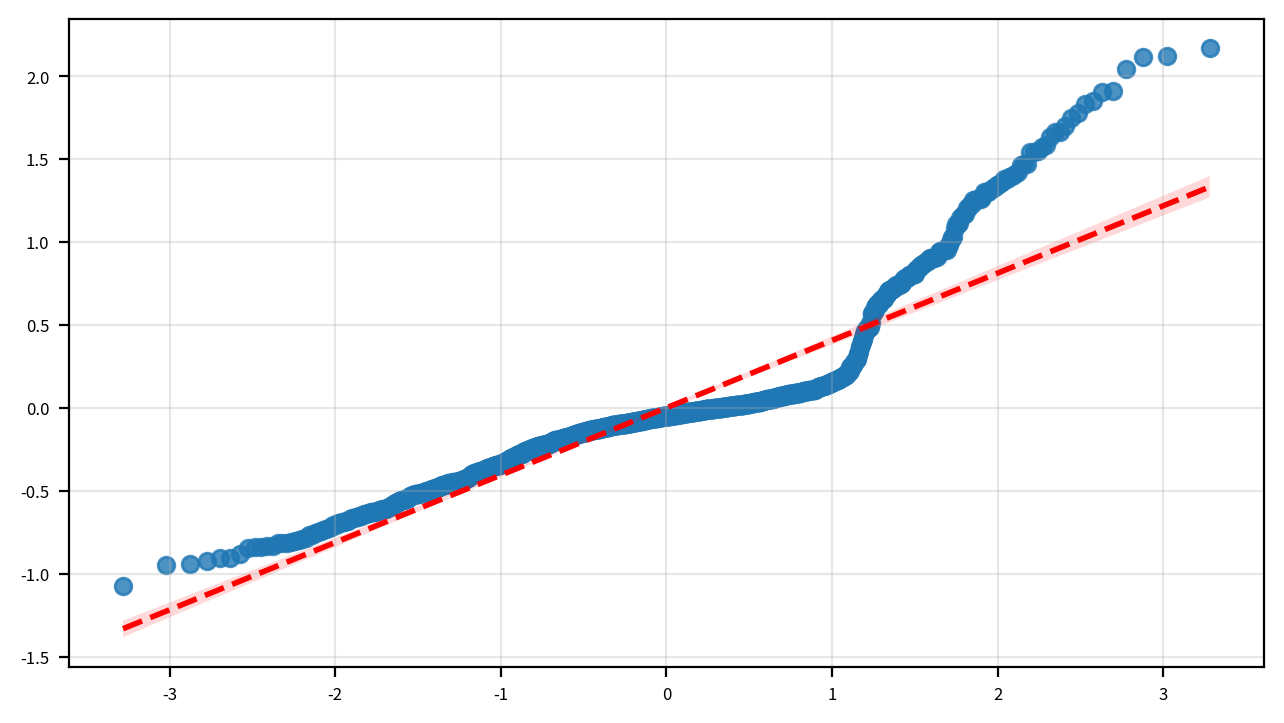

In [43]:
(x, y), _ = probplot(model.resid)

width_px  = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) regplot 그리기
sb.regplot(x=x, y=y, line_kws={
"color": "red",
"linestyle": "--",   
"linewidth": 2
            })
# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)           

plt.tight_layout()      
plt.show()              
plt.close()             

In [44]:
stats.shapiro(model.resid)

ShapiroResult(statistic=np.float64(0.8373047526556342), pvalue=np.float64(6.800944817279797e-35))

2. 선형성 검정, 결과 : 위배 가능성 있음

In [45]:
reset_res = linear_reset(model, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")
if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 287.1425
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


3.  잔차의 독립성 검정, 결과 : 독립성 만족

In [46]:
dw = durbin_watson(model.resid)

if 1.5 <= dw <= 2.5:
    interpretation = "잔차는 독립성을 만족함 (자기상관 없음)"
elif dw < 1.5:
    interpretation = "잔차에 양(+)의 자기상관이 존재할 가능성 있음 (독립성 위반)"
else:
    interpretation = "잔차에 음(–)의 자기상관이 존재할 가능성 있음 (독립성 위반)"

print(f"Durbin–Watson: {dw:.3f}")
print(interpretation)

Durbin–Watson: 2.046
잔차는 독립성을 만족함 (자기상관 없음)


4. 등분산성 검정, 결과 : 등분산 아님

In [47]:
# Breusch–Pagan Test
names = ['LM Statistic', 'LM p-value', 'F Statistic', 'F p-value']
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp = DataFrame(bp_test, index=names, columns=['value'])

# p-value는 F p-value를 기준으로 사용
p_bp = bp.loc['F p-value', 'value']

print(f"Breusch–Pagan statistic: {bp.loc['F Statistic','value']:.3f}, p-value = {p_bp:.3f}")
print(f"{'이분산성 존재(등분산 아님)' if p_bp <= 0.05 else '등분산성 만족'}")

Breusch–Pagan statistic: 10.155, p-value = 0.000
이분산성 존재(등분산 아님)


+ 다중공선성 검토

In [48]:
df10 = dfl.drop(columns = 'age_group', axis=1)
df10 = pd.get_dummies(df10, dtype = 'int', drop_first=True)
df10_1 = df10.copy()
y = df10_1.pop('charges')

In [49]:
print(df10_1.shape, df10.shape)

(1338, 8) (1338, 9)


In [50]:
vif_list2 = []
for i in range(df10_1.shape[1]):
    vif_values = variance_inflation_factor(df10_1.values, i)
    vif_list2.append(vif_values)
df7v = pd.DataFrame({
    'feature' : df10_1.columns,
    'VIF' : vif_list2
})
df7v

,feature,VIF
0,age,7.686965
1,bmi,11.358443
2,children,1.809930
3,sex_male,2.003185
4,smoker_yes,1.261233
5,region_northwest,1.890281
6,region_southeast,2.265564
7,region_southwest,1.960745


다중공선성 문제를 해결하기 위해 10이 넘는 bmi 제거

In [51]:
df10_1 = df10_1.drop(columns='bmi', axis = 1)
vif_list2 = []
for i in range(df10_1.shape[1]):
    vif_values = variance_inflation_factor(df10_1.values, i)
    vif_list2.append(vif_values)
df7v = pd.DataFrame({
    'feature' : df10_1.columns,
    'VIF' : vif_list2
})
df7v

,feature,VIF
0,age,3.850843
1,children,1.762729
2,sex_male,1.884719
3,smoker_yes,1.249792
4,region_northwest,1.706783
5,region_southeast,1.795873
6,region_southwest,1.715200


회귀분석 다시 실시

In [52]:
model10 = ols('charges ~ age + children + sex_male + smoker_yes + region_northwest + region_southeast + region_southwest', data = df10).fit()
print(model10.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     604.4
Date:                Wed, 07 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:08:10   Log-Likelihood:                -828.71
No. Observations:                1338   AIC:                             1673.
Df Residuals:                    1330   BIC:                             1715.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.3913      0.046  

유의하지 않는 칼럼 제거 후 회귀분석 재실시

In [53]:
model10 = ols('charges ~ age + children + sex_male + smoker_yes + region_southeast + region_southwest', data = df10).fit()
print(model10.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     703.5
Date:                Wed, 07 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:08:10   Log-Likelihood:                -830.32
No. Observations:                1338   AIC:                             1675.
Df Residuals:                    1331   BIC:                             1711.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.3595      0.042  

In [54]:
model10.params[:]

Intercept           7.359517
age                 0.035237
children            0.102137
sex_male           -0.067935
smoker_yes          1.552794
region_southeast   -0.069346
region_southwest   -0.078349
dtype: float64

In [55]:
model10.rsquared

np.float64(0.7602603166861159)